In [104]:
from __future__ import unicode_literals, print_function, division
import unicodedata
import numpy as np
import pandas as pd
from io import open
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import wandb
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !unzip /content/gdrive/MyDrive/aksharantar_sampled.zip > /dev/null

## DATA PROCESSING

In [106]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.chr2index = {}
        self.chr2count = {}
        self.index2chr = {0: "$", 1: "#"}
        self.n_chrs = 2 

    def addword(self, word):
        for ch in word:
            self.addchr(ch)

    def addchr(self, ch):
        if ch not in self.chr2index:
            self.chr2index[ch] = self.n_chrs
            self.chr2count[ch] = 1
            self.index2chr[self.n_chrs] = ch
            self.n_chrs += 1
        else:
            self.chr2count[ch] += 1

In [107]:
MAX_LENGTH = 25
# def unicodeToAscii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#     )


# def normalizeString(s):
#     s = unicodeToAscii(s.strip())
#     s = re.sub(r"([.!?])", r" \1", s)
#     s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
#     return s

In [108]:

def readLangs(lang1,lang2):
    pairs = ()
    for i in ['train','valid','test']:
        fd = open('aksharantar_sampled/'+lang2+'/'+lang2+'_'+i+'.csv')
        lines = fd.read().strip().split('\n')
        pairs += ([[s for s in l.split(',')] for l in lines],)
    return pairs
    

In [109]:
OUTPUT_LANGUAGE = "mni"

input_lang = Lang("eng")
output_lang = Lang(OUTPUT_LANGUAGE)
train_pairs,valid_pairs,test_pairs = readLangs("eng",OUTPUT_LANGUAGE)

for pair in train_pairs:
    input_lang.addword(pair[0])
    output_lang.addword(pair[1])
    

In [110]:
def indexesFromWord(lang, word):
    return [lang.chr2index[ch] for ch in word]


def tensorFromWord(lang,word):
    indexes = indexesFromWord(lang, word)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromWord(input_lang, pair[0])
    target_tensor = tensorFromWord(output_lang, pair[1])
    return (input_tensor, target_tensor)

## ENCODER

In [111]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_layer_size, num_encoder_layers, cell_type, dropout_prob, bidirectional):
      super(EncoderRNN, self).__init__()
      self.input_size = input_size
      self.hidden_layer_size = hidden_layer_size
      self.num_encoder_layers = num_encoder_layers
      self.cell_type = cell_type

      self.embedding = nn.Embedding(self.input_size, embedding_size)

      if cell_type == 'RNN':
        self.rnn = nn.RNN(input_size = embedding_size, hidden_size = hidden_layer_size, num_layers = num_encoder_layers, dropout = dropout_prob, bidirectional = bidirectional)
      elif cell_type == 'LSTM':
        self.rnn = nn.LSTM(input_size = embedding_size, hidden_size = hidden_layer_size, num_layers = num_encoder_layers, dropout = dropout_prob, bidirectional = bidirectional)
      elif cell_type == 'GRU':
        self.rnn = nn.GRU(input_size = embedding_size, hidden_size = hidden_layer_size, num_layers = num_encoder_layers, dropout = dropout_prob, bidirectional = bidirectional)
      self.dropout = nn.Dropout(dropout_prob)
      self.D = 1
      if bidirectional == True :
        self.D = 2

    def forward(self, input_tensor, prev_hidden, prev_cell = None):
      embedded = self.embedding(input_tensor).view(1,1,-1)
      embedded = self.dropout(embedded)
      if self.cell_type == 'RNN':
        output, hidden = self.rnn(embedded,prev_hidden)
      elif self.cell_type == 'LSTM':
        output, (hidden,cell) = self.rnn(embedded,(prev_hidden,prev_cell))
        return output, (hidden,cell)
      elif self.cell_type == 'GRU':
        output, hidden = self.rnn(embedded,prev_hidden)
        
      return output,hidden

    def initHidden(self):
      if self.cell_type == 'LSTM':
        hidden = torch.zeros(self.D*self.num_encoder_layers,1,self.hidden_layer_size,device = device)
        cell = torch.zeros(self.D*self.num_encoder_layers,1,self.hidden_layer_size,device = device)
        return hidden,cell
      else :
        hidden = torch.zeros(self.D*self.num_encoder_layers,1,self.hidden_layer_size,device = device)
      return hidden


## DECODER

In [112]:
# # class Decoder

# class DecoderRNN(nn.Module):
#   def __init__(self, output_size, embedding_size, hidden_layer_size, num_decoder_layers, cell_type, dropout_prob, bidirectional):
#     super(DecoderRNN, self).__init__()
#     self.output_size = output_size
#     self.hidden_layer_size = hidden_layer_size
#     self.num_decoder_layers = num_decoder_layers
#     self.cell_type = cell_type
#     self.embedding_size = embedding_size
#     self.embedding = nn.Embedding(output_size, embedding_size)
   
#     if cell_type == 'RNN':
#       self.rnn = nn.RNN(input_size = embedding_size, hidden_size = hidden_layer_size, num_layers = num_decoder_layers, dropout = dropout_prob, bidirectional = bidirectional)
#     elif cell_type == 'LSTM':
#       self.rnn = nn.LSTM(input_size = embedding_size, hidden_size = hidden_layer_size, num_layers = num_decoder_layers, dropout = dropout_prob, bidirectional = bidirectional)
#     elif cell_type == 'GRU':
#       self.rnn = nn.GRU(input_size = embedding_size, hidden_size = hidden_layer_size, num_layers = num_decoder_layers, dropout = dropout_prob, bidirectional = bidirectional)
      
#     self.D = 1
#     if bidirectional == True :
#       self.D = 2
      
#     self.dropout = nn.Dropout(dropout_prob)
#     self.out = nn.Linear(self.D*hidden_layer_size, output_size)
#     self.softmax = nn.LogSoftmax(dim = 1)
      
#   def forward(self, input_tensor, prev_hidden, prev_cell = None):
#     embedded = self.embedding(input_tensor).view(1,1,-1)
#     embedded = F.relu(embedded)
#     embedded = self.dropout(embedded)
    
#     if self.cell_type == 'RNN':
#       output, hidden = self.rnn(embedded,prev_hidden)
      
#     elif self.cell_type == 'LSTM':
#       output,(hidden,cell) = self.rnn(embedded,(prev_hidden,prev_cell))
    
#     elif self.cell_type == 'GRU':
#       output, hidden = self.rnn(embedded,prev_hidden)

#     output = self.softmax(self.out(output[0]))

#     if self.cell_type == 'LSTM':
#       return output,(hidden,cell)
    
#     return output, hidden

## Attention Decoder

In [113]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_layer_size, num_decoder_layers, cell_type, dropout_prob, bidirectional, max_length = MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_layer_size = hidden_layer_size
        self.num_decoder_layers = num_decoder_layers
        self.cell_type = cell_type
        self.embedding_size = embedding_size
        self.max_length = max_length
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.dropout = nn.Dropout(dropout_prob)
        if bidirectional == True :
          self.D = 2
        else :
          self.D = 1

        self.attn = nn.Linear(self.hidden_layer_size + self.embedding_size, self.max_length)
        self.attn_combine = nn.Linear(self.D*self.hidden_layer_size + self.embedding_size, self.embedding_size)
        
        if cell_type == 'RNN':
          self.rnn = nn.RNN(input_size = embedding_size, hidden_size = hidden_layer_size, num_layers = num_decoder_layers, dropout = dropout_prob, bidirectional = bidirectional)
        elif cell_type == 'LSTM':
          self.rnn = nn.LSTM(input_size = embedding_size, hidden_size = hidden_layer_size, num_layers = num_decoder_layers, dropout = dropout_prob, bidirectional = bidirectional)
        elif cell_type == 'GRU':
          self.rnn = nn.GRU(input_size = embedding_size, hidden_size = hidden_layer_size, num_layers = num_decoder_layers, dropout = dropout_prob, bidirectional = bidirectional)

        self.out = nn.Linear(self.D*self.hidden_layer_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input_tensor, prev_hidden, encoder_outputs, prev_cell = None):
        embedded = self.embedding(input_tensor).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], prev_hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)

        if self.cell_type == 'RNN':
          output, hidden = self.rnn(embedded,prev_hidden)
          
        elif self.cell_type == 'LSTM':
          output,(hidden,cell) = self.rnn(embedded,(prev_hidden,prev_cell))
        
        elif self.cell_type == 'GRU':
          output, hidden = self.rnn(embedded,prev_hidden)

        output = self.softmax(self.out(output[0]))

        if self.cell_type == 'LSTM':
          return output, (hidden,cell), attn_weights

        return output, hidden, attn_weights


## Train

In [114]:
def train(input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,max_length = MAX_LENGTH,teacher_forcing_ratio = 0.5):
    
    if encoder.cell_type == 'LSTM':
      encoder_hidden,encoder_cell = encoder.initHidden()
    else :
      encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.D*encoder.hidden_layer_size, device=device)
    
    loss = 0
    
    for ei in range(input_length):
      if encoder.cell_type == 'LSTM':
        encoder_output,(encoder_hidden,encoder_cell) = encoder(input_tensor = input_tensor[ei],prev_hidden = encoder_hidden,prev_cell = encoder_cell)
      else :
        encoder_output, encoder_hidden = encoder(input_tensor = input_tensor[ei], prev_hidden = encoder_hidden)
      # print(encoder_output.size())
      encoder_outputs[ei] = encoder_output[0][0]
      
    decoder_input = torch.tensor([[SOS_token]],device=device)
    # decoder_outputs = torch.zeros(target_length)
    decoder_hidden = encoder_hidden
    if decoder.cell_type == 'LSTM':
      decoder_cell = encoder_cell
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing :
      for di in range(target_length):
        if decoder.cell_type == 'LSTM':
          decoder_output,(decoder_hidden,decoder_cell), decoder_attention = decoder(input_tensor = decoder_input,prev_hidden = decoder_hidden,encoder_outputs = encoder_outputs,prev_cell = decoder_cell)
        else:
          decoder_output, decoder_hidden, decoder_attention = decoder(input_tensor = decoder_input,prev_hidden = decoder_hidden,encoder_outputs = encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]

    else :
      for di in range(target_length):
        if decoder.cell_type == 'LSTM':
          decoder_output,(decoder_hidden,decoder_cell), decoder_attention = decoder(input_tensor = decoder_input,prev_hidden = decoder_hidden,encoder_outputs = encoder_outputs,prev_cell = decoder_cell)
        else:
          decoder_output, decoder_hidden, decoder_attention = decoder(input_tensor = decoder_input,prev_hidden = decoder_hidden,encoder_outputs = encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()
        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
          break
    
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length
        
      

In [115]:
training_pairs = [tensorsFromPair(pair) for pair in train_pairs]
def trainIters(encoder,decoder,encoder_optimizer,decoder_optimizer,criterion):
    
    training_loss = 0
    it = 0
    for pair in training_pairs:
        input_tensor = pair[0]
        target_tensor = pair[1]
        loss = train(input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion)
        training_loss += loss
        # if it % 500 == 0:
        #     print(it,"words done")
        it += 1
    return training_loss/len(training_pairs)

## Evaluate

In [116]:
def evaluate(encoder,decoder,word,target = None,criterion = None,max_length = MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromWord(input_lang,word)
        input_length = input_tensor.size()[0]
        target_length = 0
        if target != None:
            target_tensor = tensorFromWord(output_lang,target)
            target_length = target_tensor.size(0)
        
        loss = 0
        
        if encoder.cell_type == 'LSTM':
            encoder_hidden,encoder_cell = encoder.initHidden()
        else :
            encoder_hidden = encoder.initHidden()
            
        encoder_outputs = torch.zeros(max_length,encoder.D*encoder.hidden_layer_size,device=device)
        
        for ei in range(input_length):
            if encoder.cell_type == 'LSTM':
                encoder_output,(encoder_hidden,encoder_cell) = encoder(input_tensor = input_tensor[ei],prev_hidden = encoder_hidden,prev_cell = encoder_cell)
            else :
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        decoder_input = torch.tensor([[SOS_token]],device=device)
        decoder_hidden = encoder_hidden
        if decoder.cell_type == 'LSTM':
            decoder_cell = encoder_cell
            
        decoded_word = ''
        

        for di in range(max_length):
            if decoder.cell_type == 'LSTM':
              decoder_output,(decoder_hidden,decoder_cell), decoder_attention = decoder(input_tensor = decoder_input,prev_hidden = decoder_hidden,encoder_outputs = encoder_outputs,prev_cell = decoder_cell)
            else:
              decoder_output, decoder_hidden, decoder_attention = decoder(input_tensor = decoder_input,prev_hidden = decoder_hidden,encoder_outputs = encoder_outputs)
            topv, topi = decoder_output.topk(1)
            
            if di<target_length:
                loss += criterion(decoder_output,target_tensor[di])
                
            if topi.item() == EOS_token:
                decoded_word += '#'
                break
            else :
                decoded_word += output_lang.index2chr[topi.item()]
                
            decoder_input = topi.squeeze().detach()
        
        return decoded_word,loss/input_length
            
def evaluateRandomly(encoder,decoder,n=10):
    for i in range(n):
        pair = random.choice(train_pairs[:10])
        print('>', pair[0])
        print('=', pair[1])
        output_word = evaluate(encoder, decoder, pair[0])
        print('<', output_word)
        print('')

def eval_acc_test(encoder,decoder,pairs,criterion = None):
    count = 0
    tot_loss = 0
    for pair in pairs:
        pred_word,loss = evaluate(encoder,decoder,pair[0],target=pair[1],criterion=criterion)
        tot_loss += loss
        print('>', pair[0])
        print('=', pair[1])
        print('<',pred_word)
        if pred_word[:-1] == pair[1] : count += 1
    return float(count/len(pairs)),float(tot_loss/(len(pairs)))

def eval_acc(encoder,decoder,pairs,criterion = None):
    count = 0
    tot_loss = 0
    for pair in pairs:
        pred_word,loss = evaluate(encoder,decoder,pair[0],target=pair[1],criterion=criterion)
        tot_loss += loss
        if pred_word[:-1] == pair[1] : count += 1
    return float(count/len(pairs)),tot_loss

def run(encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,epochs):
    for epoch in range(epochs): 
        train_loss = trainIters(encoder=encoder,decoder=decoder,encoder_optimizer=encoder_optimizer,decoder_optimizer=decoder_optimizer,criterion = criterion)
        train_acc,_ = eval_acc(encoder,decoder,random.sample(train_pairs,1000),criterion)
        valid_acc,valid_loss = eval_acc(encoder,decoder,valid_pairs,criterion)
        print("Epoch : %d, Training Loss : %f, Training Accuracy : %f, Validation Loss = %f, Validation Accuracy : %f" % (epoch+1,train_loss,train_acc,valid_loss,valid_acc)) 
    
        

In [117]:
def evaluate_with_Attentions(encoder,decoder,word,target = None,criterion = None,max_length = MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromWord(input_lang,word)
        input_length = input_tensor.size()[0]
        target_length = 0
        if target != None:
            target_tensor = tensorFromWord(output_lang,target)
            target_length = target_tensor.size(0)
        
        loss = 0
        
        if encoder.cell_type == 'LSTM':
            encoder_hidden,encoder_cell = encoder.initHidden()
        else :
            encoder_hidden = encoder.initHidden()
            
        encoder_outputs = torch.zeros(max_length,encoder.D*encoder.hidden_layer_size,device=device)
        
        for ei in range(input_length):
            if encoder.cell_type == 'LSTM':
                encoder_output,(encoder_hidden,encoder_cell) = encoder(input_tensor = input_tensor[ei],prev_hidden = encoder_hidden,prev_cell = encoder_cell)
            else :
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        decoder_input = torch.tensor([[SOS_token]],device=device)
        decoder_hidden = encoder_hidden
        if decoder.cell_type == 'LSTM':
            decoder_cell = encoder_cell
            
        decoded_word = ''
        
        attentions = []
        
        for di in range(max_length):
            if decoder.cell_type == 'LSTM':
              decoder_output,(decoder_hidden,decoder_cell), decoder_attention = decoder(input_tensor = decoder_input,prev_hidden = decoder_hidden,encoder_outputs = encoder_outputs,prev_cell = decoder_cell)
            else:
              decoder_output, decoder_hidden, decoder_attention = decoder(input_tensor = decoder_input,prev_hidden = decoder_hidden,encoder_outputs = encoder_outputs)
            topv, topi = decoder_output.topk(1)
            
            attentions.append(decoder_attention)
            
            if di<target_length:
                loss += criterion(decoder_output,target_tensor[di])
                
            if topi.item() == EOS_token:
                decoded_word += '#'
                break
            else :
                decoded_word += output_lang.index2chr[topi.item()]
                
            decoder_input = topi.squeeze().detach()
        
        attentions = torch.stack(attentions)
        
        return decoded_word,loss/input_length,attentions

## Training 

In [43]:
# input_size = input_lang.n_chrs
# output_size = output_lang.n_chrs
# embedding_size = 256
# hidden_layer_size = 128
# num_layers = 2
# cell_type = 'LSTM'
# dropout_prob = 0.2
# learning_rate = 0.001
# bidirectional = True
# epochs = 15

# encoder = EncoderRNN(input_size=input_size,embedding_size=embedding_size,hidden_layer_size=hidden_layer_size,num_encoder_layers=num_layers,cell_type=cell_type,dropout_prob=dropout_prob,bidirectional=bidirectional).to(device)
# decoder = AttnDecoderRNN(output_size=output_size,embedding_size=embedding_size,hidden_layer_size=hidden_layer_size,num_decoder_layers=num_layers,cell_type=cell_type,dropout_prob=dropout_prob,bidirectional=bidirectional).to(device)
# encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
# criterion = nn.NLLLoss()
# run(encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,epochs)

## Best Hyperparameters

In [44]:
input_size = input_lang.n_chrs
output_size = output_lang.n_chrs
embedding_size = 256
hidden_layer_size = 128
num_layers = 2
cell_type = 'LSTM'
dropout_prob = 0.2
learning_rate = 0.001
bidirectional = True
epochs = 10

encoder = EncoderRNN(input_size=input_size,embedding_size=embedding_size,hidden_layer_size=hidden_layer_size,num_encoder_layers=num_layers,cell_type=cell_type,dropout_prob=dropout_prob,bidirectional=bidirectional).to(device)
decoder = AttnDecoderRNN(output_size=output_size,embedding_size=embedding_size,hidden_layer_size=hidden_layer_size,num_decoder_layers=num_layers,cell_type=cell_type,dropout_prob=dropout_prob,bidirectional=bidirectional).to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
run(encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,epochs)
test_accuracy,test_loss = eval_acc_test(encoder,decoder,test_pairs,criterion)

Epoch : 1, Training Loss : 1.274746, Training Accuracy : 0.369000, Validation Loss = 2471.982910, Validation Accuracy : 0.367791
Epoch : 2, Training Loss : 0.629917, Training Accuracy : 0.546000, Validation Loss = 1931.482910, Validation Accuracy : 0.501227
Epoch : 3, Training Loss : 0.480415, Training Accuracy : 0.594000, Validation Loss = 1735.136353, Validation Accuracy : 0.537423
Epoch : 4, Training Loss : 0.408155, Training Accuracy : 0.647000, Validation Loss = 1636.569946, Validation Accuracy : 0.571166
Epoch : 5, Training Loss : 0.347681, Training Accuracy : 0.698000, Validation Loss = 1658.737427, Validation Accuracy : 0.605521
Epoch : 6, Training Loss : 0.322505, Training Accuracy : 0.719000, Validation Loss = 1597.637085, Validation Accuracy : 0.601227
Epoch : 7, Training Loss : 0.292504, Training Accuracy : 0.751000, Validation Loss = 1568.487305, Validation Accuracy : 0.618405
Epoch : 8, Training Loss : 0.287668, Training Accuracy : 0.747000, Validation Loss = 1551.970581,

In [45]:
print("Test Accuracy : %f" % (test_accuracy))

Test Accuracy : 0.398438


In [46]:
# Save the model
PATH = "./AttnDec_models/"
torch.save(encoder.state_dict(),PATH+'encoder.pt')
torch.save(decoder.state_dict(),PATH+'decoder.pt')

## Plotting HeatMaps

In [118]:
input_size = input_lang.n_chrs
output_size = output_lang.n_chrs
embedding_size = 256
hidden_layer_size = 128
num_layers = 2
cell_type = 'LSTM'
dropout_prob = 0.2
learning_rate = 0.001
bidirectional = True
epochs = 15

encoder = EncoderRNN(input_size=input_size,embedding_size=embedding_size,hidden_layer_size=hidden_layer_size,num_encoder_layers=num_layers,cell_type=cell_type,dropout_prob=dropout_prob,bidirectional=bidirectional).to(device)
decoder = AttnDecoderRNN(output_size=output_size,embedding_size=embedding_size,hidden_layer_size=hidden_layer_size,num_decoder_layers=num_layers,cell_type=cell_type,dropout_prob=dropout_prob,bidirectional=bidirectional).to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
encoder.load_state_dict(torch.load("./AttnDec_models/encoder.pt"))
decoder.load_state_dict(torch.load("./AttnDec_models/decoder.pt"))

attentions_list = []
pairs = random.sample(test_pairs,10)
for pair in pairs :
    pred_word,loss,attn = evaluate_with_Attentions(encoder,decoder,pair[0],target=pair[1],criterion=criterion)
    attentions_list.append(attn)

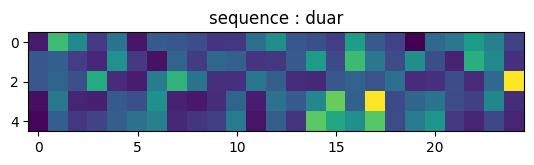

In [121]:
import numpy as np
import matplotlib.pyplot as plt
# wandb.init(project="Assignment_3")
for i in range(len(attentions_list)):
    plt.title("sequence : "+pairs[i][0])
    plt.imshow(torch.squeeze(attentions_list[i]))
    # plt.show()
    plt.savefig("attn_heatmaps/"+pairs[i][0]+"_heatmap.jpg")
    # wandb.log({pairs[i][0]+"_heatmap": wandb.Image("attn_heatmaps/"+pairs[i][0]+"_heatmap.jpg")})
    # wandb.plot()
# wandb.finish()